In [7]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("../data/huckleberry_14aug2024.csv", parse_dates=["Start", "End"])
df["Duration"] = df["End"] - df["Start"]
df["Duration_minutes"] = df["Duration"].dt.seconds / 60
# Remove first day
df = df[df["Start"].dt.date >= datetime.date(2024, 7, 27)]
df = df.sort_values("Start")
df

,Type,Start,End,Duration,Start Condition,Start Location,End Condition,Notes,Duration_minutes
547,Sleep,2024-07-27 00:00:00,2024-07-27 00:11:00,0 days 00:11:00,NaN,NaN,NaN,NaN,11.0
546,Feed,2024-07-27 00:22:00,2024-07-27 00:31:00,0 days 00:09:00,00:00R,Breast,00:08L,NaN,9.0
545,Diaper,2024-07-27 00:46:00,NaT,NaT,NaN,NaN,Both,NaN,NaN
544,Feed,2024-07-27 00:49:00,2024-07-27 01:07:00,0 days 00:18:00,Null r,Breast,00:18L,NaN,18.0
543,Feed,2024-07-27 01:17:00,2024-07-27 01:27:00,0 days 00:10:00,00:10R,Breast,Null l,NaN,10.0
...,...,...,...,...,...,...,...,...,...
4,Feed,2024-08-14 06:06:00,2024-08-14 06:24:00,0 days 00:18:00,00:17R,Breast,Null l,NaN,18.0
3,Sleep,2024-08-14 06:28:00,2024-08-14 09:35:00,0 days 03:07:00,NaN,NaN,NaN,NaN,187.0
2,Feed,2024-08-14 09:52:00,2024-08-14 10:45:00,0 days 00:53:00,00:30R,Breast,00:22L,NaN,53.0
1,Diaper,2024-08-14 11:11:00,NaT,NaT,NaN,NaN,Pee,NaN,NaN


In [9]:
df["Start_date"] = df["Start"].dt.date
df["Start_time"] = df["Start"].dt.time
df["End_date"] = df["End"].dt.date

In [10]:
# Break around the 24hour mark
across_midnight = df.query("Type=='Sleep' and Start_date != End_date")
new_entries = []
for i, row in across_midnight.iterrows():
    bef_row = row.copy()
    bef_row["End"] = datetime.datetime(year=row["End"].year, month=row["End"].month, day=row["End"].day)
    bef_row["Duration"] = bef_row["End"] - bef_row["Start"]
    bef_row["Duration_minutes"] = bef_row["Duration"].seconds / 60
    bef_row["Start_date"] = bef_row["Start"].date()
    bef_row["Start_time"] = bef_row["Start"].time()
    bef_row["End_date"] = bef_row["End"].date()
    new_entries.append(bef_row)
    
    aft_row = row.copy()
    aft_row["Start"] = datetime.datetime(year=row["End"].year, month=row["End"].month, day=row["End"].day)
    aft_row["Duration"] = aft_row["End"] - aft_row["Start"]
    aft_row["Duration_minutes"] = aft_row["Duration"].seconds / 60
    aft_row["Start_date"] = aft_row["Start"].date()
    aft_row["Start_time"] = aft_row["Start"].time()
    aft_row["End_date"] = aft_row["End"].date()
    new_entries.append(aft_row)
    
df = (
    pd.concat(
        [
            df.query("not (Type=='Sleep' and Start_date != End_date)"), 
            pd.DataFrame(new_entries),
        ]
    )
    .reset_index(drop=True)
    .sort_values("Start")
)

In [11]:
sdf = df.query("Type=='Sleep'")

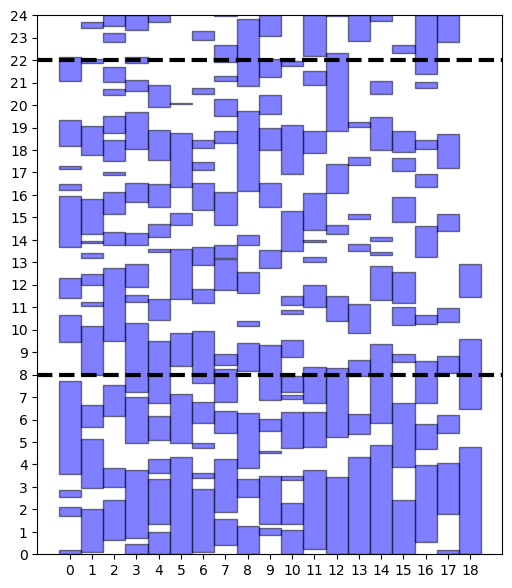

In [12]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from datetime import timedelta

fg, ax = plt.subplots(figsize=(6, 7))

# Loop over data points; create box from errors at each point
rectangles = [
    Rectangle(
        (
            row["Start_date"].timetuple().tm_yday, 
            row["Start_time"].hour * 60 + row["Start_time"].minute,
        ),
        1, 
        row["Duration_minutes"],
    )
    for idx, row in sdf.iterrows()
]
pc = PatchCollection(rectangles, facecolor="blue", alpha=0.5, ec="k")
ax.add_collection(pc)
ax.plot()

min_day = sdf["Start_date"].values.min().timetuple().tm_yday
max_day = sdf["Start_date"].values.max().timetuple().tm_yday
ax.set_xticks(np.arange(max_day-min_day+1) + min_day + 0.5)
ax.set_xticklabels(np.arange(max_day-min_day+1))
ax.set_yticks(np.arange(25) * 60);
ax.set_yticklabels(np.arange(25));
ax.set_ylim([0, 24*60])
ax.axhline([8*60], color="k", ls="--", lw=3)
ax.axhline([22*60], color="k", ls="--", lw=3);